In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
from quadratic_weighted_kappa import quadratic_weighted_kappa

In [4]:
xgb.__version__,xgb.__file__

('0.6', '../third/xgboost/python-package/build/lib/xgboost/__init__.pyc')

In [5]:
import fastparquet
%time df=fastparquet.ParquetFile("../input/train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 1.63 s, sys: 2.81 s, total: 4.44 s
Wall time: 4.44 s


In [6]:
df.shape

(6582476, 55)

In [8]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582476 entries, 0 to 15203954
Columns: 55 entries, market to id_count
dtypes: float32(53), int8(2)
memory usage: 1.4 GB


In [9]:
(df.index<10000000).sum(),(df.target<0).sum()

(1378521, 1378521)

In [10]:
testx=df[df.index<10000000].drop(['target','date'],axis=1)
testx.shape

(1378521, 53)

In [11]:
df=df[df.index>=10000000]

In [12]:
df.shape

(5203955, 55)

In [13]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203955 entries, 10000000 to 15203954
Columns: 55 entries, market to id_count
dtypes: float32(53), int8(2)
memory usage: 1.1 GB


In [14]:
import gc
gc.collect()

9987

In [36]:
import numpy as np
from numba import jit 

def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    w = np.zeros((max_rat + 1, max_rat + 1))
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            w[i, j] = (i - j) * (i - j)/ float(max_rat * max_rat)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for i, j in zip(a1, a2):
        hist1[i] += 1
        hist2[j] += 1
        o +=  w[i, j]

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * w[i, j]

    e = e / float(a1.shape[0])

    return 1 - o / e

@jit
def qwk3(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e

def eval_qwk(preds, dtrain):
    labels = dtrain.get_label()
    preds=clip_pred(preds)
    qwk_score = qwk3(labels, preds)
    return [('qwk', qwk_score)]

In [15]:
df.head()

market  date       f_0       f_1       f_2       f_3       f_4  \
id                                                                           
10000000  3.981910    16  4.084971  4.256005  4.576220  0.011423  0.023838   
10000001  4.600824    16  4.572433  4.589514  4.622002  1.042093  0.922797   
10000002  4.266003    16  4.357457  4.589514  4.576220  1.441485  1.664050   
10000003  4.600824    16  4.434495  4.589514  4.576220  0.721977  0.306136   
10000004  4.600824    16  4.659207  4.589514  4.576220  1.201324  0.776684   

               f_5       f_6       f_7    ...     latest_target  count  \
id                                        ...                            
10000000  2.279448  0.000000  4.327717    ...               1.0    1.0   
10000001  4.191009  0.000000  4.336779    ...               2.0    4.0   
10000002  7.959006  0.006247  4.385122    ...               1.0    1.0   
10000003  2.859509  0.000000  4.336779    ...               3.0    2.0   
10000004  2.859509  0.000000  4.336779    ...               2.0    4.0   

              freq  latest3_mean  changed_count  latest2_change  latest2_mean  \
id                                                                              
10000000  1.000000       -9999.0            0.0         -9999.0       -9999.0   
10000001  1.000000          33.0            2.0            -2.0          30.0   
10000002  1.000000       -9999.0            0.0         -9999.0       -9999.0   
10000003  1.000000       -9999.0            1.0             1.0          25.0   
10000004  0.666667          50.0            2.0            -6.0          50.0   

          mkt_mean  mkt_count  id_count  
id                                       
10000000     1.000        3.0       3.0  
10000001     3.875        2.0      10.0  
10000002     3.000        5.0      20.0  
10000003     2.500        1.0       2.0  
10000004     4.500        2.0       5.0  

[5 rows x 55 columns]

In [43]:
cols=[u for u in df.columns if not u.startswith('f_') and u not in ['market','date','target']]
cols

['age',
 'latest_target',
 'count',
 'freq',
 'latest3_mean',
 'changed_count',
 'latest2_change',
 'latest2_mean',
 'mkt_mean',
 'mkt_count',
 'id_count']

In [20]:
dates=df['date']

In [29]:
trainx=df.drop(['target','date'],axis=1)
trainy=df['target']

In [32]:
set(dates)

{5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [33]:
trainidx=dates<15
testidx=~trainidx

In [44]:
x_train, y_train, x_valid, y_valid = trainx[trainidx], trainy[trainidx], trainx[testidx], trainy[testidx]


In [45]:
excluded_cols=[]

In [47]:
for col in cols:
    if col in excluded_cols: continue
    print "Start===== ", col, excluded_cols
    print('Building DMatrix...')

    d_train = xgb.DMatrix(x_train.drop(excluded_cols+[col],axis=1), label=y_train)
    d_valid = xgb.DMatrix(x_valid.drop(excluded_cols+[col],axis=1), label=y_valid)

    print x_train.shape,x_valid.shape
    print('Training ...')

    params = {}
    params['eta'] = 0.2
    params['objective'] = 'reg:linear'
    params['eval_metric'] = 'rmse'
    params['max_depth'] = 8
    params['nthread']=8
    params['silent'] = 1
    params['tree_method']='hist'

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    %time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40,feval=eval_qwk,maximize=True)


Start=====  age []
Building DMatrix...
(4325056, 53) (878899, 53)
Training ...
[0]	train-rmse:4.19902	valid-rmse:4.26428	train-qwk:0.095148	valid-qwk:0.093201
Multiple eval metrics have been passed: 'valid-qwk' will be used for early stopping.

Will train until valid-qwk hasn't improved in 50 rounds.
[40]	train-rmse:1.86246	valid-rmse:1.88825	train-qwk:0.750084	valid-qwk:0.744433
[80]	train-rmse:1.84863	valid-rmse:1.88733	train-qwk:0.754315	valid-qwk:0.745145
[120]	train-rmse:1.83668	valid-rmse:1.88674	train-qwk:0.757734	valid-qwk:0.745799
[160]	train-rmse:1.82764	valid-rmse:1.88725	train-qwk:0.760193	valid-qwk:0.746057
Stopping. Best iteration:
[147]	train-rmse:1.83076	valid-rmse:1.88672	train-qwk:0.759324	valid-qwk:0.746097

CPU times: user 19min 37s, sys: 27.6 s, total: 20min 4s
Wall time: 2min 39s
Start=====  latest_target []
Building DMatrix...
(4325056, 53) (878899, 53)
Training ...
[0]	train-rmse:4.19909	valid-rmse:4.26416	train-qwk:0.096575	valid-qwk:0.0948
Multiple eval metric

In [35]:
x_train.shape,x_valid.shape

((4325056, 53), (878899, 53))

In [38]:
print('Training ...')

params = {}
params['eta'] = 0.2
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['max_depth'] = 8
params['nthread']=8
params['silent'] = 1
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40,feval=eval_qwk,maximize=True)


Training ...
[0]	train-rmse:4.19902	valid-rmse:4.26433	train-qwk:0.095148	valid-qwk:0.093201
Multiple eval metrics have been passed: 'valid-qwk' will be used for early stopping.

Will train until valid-qwk hasn't improved in 50 rounds.
[40]	train-rmse:1.86191	valid-rmse:1.88776	train-qwk:0.750102	valid-qwk:0.744608
[80]	train-rmse:1.84704	valid-rmse:1.88593	train-qwk:0.754671	valid-qwk:0.746061
[120]	train-rmse:1.83651	valid-rmse:1.88586	train-qwk:0.757621	valid-qwk:0.746523
[160]	train-rmse:1.82661	valid-rmse:1.88635	train-qwk:0.760435	valid-qwk:0.746547
[200]	train-rmse:1.81876	valid-rmse:1.88667	train-qwk:0.762673	valid-qwk:0.746784
[240]	train-rmse:1.81047	valid-rmse:1.88751	train-qwk:0.76494	valid-qwk:0.746621
Stopping. Best iteration:
[193]	train-rmse:1.82002	valid-rmse:1.88658	train-qwk:0.762295	valid-qwk:0.746843

CPU times: user 24min 6s, sys: 34.3 s, total: 24min 40s
Wall time: 3min 15s


In [27]:
print('Training ...')

params = {}
params['eta'] = 0.2
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['max_depth'] = 8
params['nthread']=8
params['silent'] = 1
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40,feval=eval_qwk,maximize=True)


Training ...
[0]	train-rmse:4.19902	valid-rmse:4.26414	train-qwk:0.095148	valid-qwk:0.093201
Multiple eval metrics have been passed: 'valid-qwk' will be used for early stopping.

Will train until valid-qwk hasn't improved in 50 rounds.
[40]	train-rmse:1.8614	valid-rmse:1.8863	train-qwk:0.750395	valid-qwk:0.745291
[80]	train-rmse:1.84707	valid-rmse:1.88494	train-qwk:0.754659	valid-qwk:0.745644
[120]	train-rmse:1.83651	valid-rmse:1.88445	train-qwk:0.757697	valid-qwk:0.745924
[160]	train-rmse:1.8273	valid-rmse:1.8848	train-qwk:0.760344	valid-qwk:0.745771
Stopping. Best iteration:
[120]	train-rmse:1.83651	valid-rmse:1.88445	train-qwk:0.757697	valid-qwk:0.745924

CPU times: user 17min 57s, sys: 24.6 s, total: 18min 21s
Wall time: 2min 27s


In [28]:
pd.Series(clf.get_fscore()).sort_values()

changed_count       81
count               95
f_34                96
f_29                99
f_9                101
f_37               140
f_1                151
f_16               152
f_10               168
freq               182
f_39               184
f_2                207
f_24               230
f_6                273
f_20               274
mkt_count          292
latest3_mean       303
f_31               304
age                451
f_41               511
f_23               548
f_38               597
f_25               600
f_33               612
id_count           615
f_32               620
f_40               623
latest2_change     625
latest2_mean       635
f_0                738
f_35               749
f_5                769
f_22               781
f_27               790
f_12               817
f_26               833
f_30               857
f_17               864
f_28               877
f_4                909
f_14               978
f_18              1082
f_3               1086
f_11       

In [23]:
def scale_pred(y_true, y_pred):
    B=np.mean((y_true-y_true.mean())**2)
    C=np.mean((y_pred-y_pred.mean())**2)
    A=np.mean((y_true-y_pred)**2)
    
    print A,B,C, (C-A+B)/(C+B)
    
    b=np.arange(-1,1.3,0.01)
    bb=(b*(C-A)+B)/(C+b**2*B)
    print max(bb)
    plt.plot(b,bb)
    return (B/(A-C))
def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

In [24]:
pred=clf.predict(d_valid)

In [25]:
lst=[]
for s in np.arange(1.25,1.35,0.01):
    a= s, quadratic_weighted_kappa(y_valid,clip_pred((pred-pred.mean())*s+pred.mean()))
    print a
    lst.append(a)

(1.25, 0.7728946336380992)
(1.26, 0.7730647036848839)
(1.27, 0.7731706270334121)
(1.28, 0.7732078765373636)
(1.29, 0.7732220523756655)
(1.3, 0.7731795269095612)
(1.3100000000000001, 0.7730849404950475)
(1.3200000000000001, 0.7729910577157908)
(1.3300000000000001, 0.7728890624342494)
(1.3400000000000001, 0.7726567307679794)
(1.3500000000000001, 0.7724361421778853)


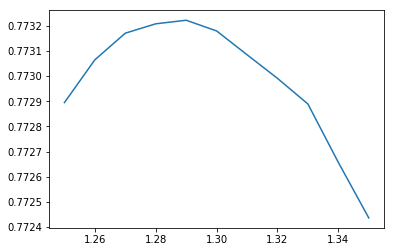

In [26]:
plt.plot(np.array(lst).T[0],np.array(lst).T[1])

In [27]:
pred=clip_pred(pred)

In [28]:
quadratic_weighted_kappa(y_valid,pred)

0.7496282226546537

In [29]:
raw_pred=clf.predict(d_train)

In [30]:
pred=clip_pred(raw_pred)
quadratic_weighted_kappa(y_train,pred)

0.7654559556845046

In [31]:
for s in np.arange(1.1,1.41,0.05):
    pred=(raw_pred-raw_pred.mean())*s+raw_pred.mean()
    pred=clip_pred(pred)
    print s, np.round(quadratic_weighted_kappa(y_train,pred),3)

1.1 0.78
1.15 0.784
1.2 0.787
1.25 0.789
1.3 0.789
1.35 0.788
1.4 0.787


# test pred

In [32]:
pred=clip_pred(clf.predict(d_test))

In [33]:
pred.shape

(1378521,)

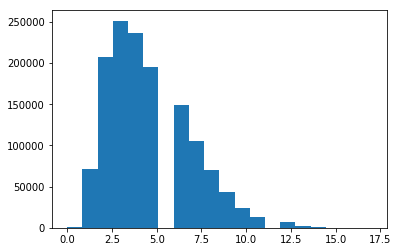

In [34]:
plt.hist(pred,bins=20);

In [35]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

/home/spark/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [36]:
sample_sub.shape

(1378521, 1)

In [37]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [38]:
this_sub=this_sub.loc[sample_sub.index]

In [39]:
this_sub.isnull().sum()

target    0
dtype: int64

In [40]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [41]:
make_submission(this_sub,"../submission/simple_xgb_combined.csv")

rm: cannot remove ‘../submission/simple_xgb_combined.csv.7z’: No such file or directory


# test pred2

In [42]:
pred=(clf.predict(d_test))

In [43]:
pred.shape

(1378521,)

In [44]:
pred.mean()

4.5412698

In [45]:
pred=(pred-pred.mean())*1.29+pred.mean()

In [46]:
pred=clip_pred(pred)

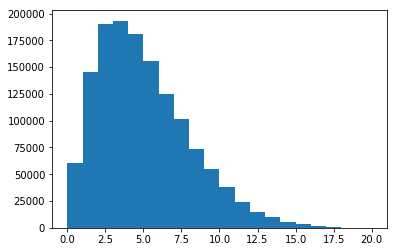

In [47]:
plt.hist(pred,bins=20);

In [48]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

In [49]:
sample_sub.shape

(1378521, 1)

In [50]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [51]:
this_sub=this_sub.loc[sample_sub.index]

In [52]:
this_sub.isnull().sum()

target    0
dtype: int64

In [53]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [54]:
make_submission(this_sub,"../submission/simple_xgb_combined_s1.29.csv")

rm: cannot remove ‘../submission/simple_xgb_combined_s1.29.csv.7z’: No such file or directory
